### **CARTPOLE DDQN KERAS**

**(soft update Polyak + some improvements)**

This is a naive version vectorized of the DDQN Algorithm for the CARTPOLE env <br>
Vectorizing we obtain a version that is faster and it is 'functional' as it works <br>
It should converge around 100 episodes

The Double DQN (DDQN) uses two networks one as a target and one as the trained network <br>

The target network is a copy of the online network that is updated less frequently, <br>
and is used to generate the target values for the Q-learning update

It includes a soft update of the weights, instead of substituting the weights between the networks it blends them together using a Polyak averaging This was an improvement on the pure DDQN algorithm

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import gymnasium as gym
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import deque
import random

import time
from PIL import Image

import sys
sys.stderr = open('err.txt', 'w')

I0000 00:00:1739102726.526854   17238 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739102726.545014   17238 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739102726.545052   17238 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739102726.683450   17238 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1739102726.683497   17238 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [2]:
# Activate GPU
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


#### **Environment setup**

In [3]:
# GPU
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
gpu_devices = [device for device in devices if device.device_type == 'GPU']
for gpu in gpu_devices:
    print('Using', gpu.physical_device_desc)

Using device: 0, name: NVIDIA T600 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
tf.random.set_seed(221)                      # For reproducibility

#### **Hyperparameters**

In [5]:
ROLLING_WINDOW=20

episodes = 300
batch_size = 64
gamma = 0.99                # Discount factor
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.99 
learning_rate = 0.0001
buffer_capacity = 10000
num_episodes = 1000
solved_threshold = 195
retrain_steps = 5           # We copy weights every retrain_steps 
tau = 0.15                   # Soft update, it is high for long retrain periods. Small for short retrain

#lr: 0.0001 gamma 0.99 batch_size 128 tau  0.15 epsilon decay 0.99 retrain_steps  5

#### **Neural Network definition**

In [6]:
# Build the neural network model
def build_model(state_size, action_size):
    inputs = Input(shape=(state_size,))  
    x = Dense(16, activation="relu")(inputs)
    x = Dense(64, activation="relu")(x)
    x = Dense(16, activation="relu")(x)
    outputs = Dense(action_size, activation="linear")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")
    return model

#### **Support Functions**

In [7]:
# Soft update function for target network
""" Soft Update using Polyak optimization """
def soft_update(model, target_model, tau):
    target_weights = target_model.get_weights()
    model_weights = model.get_weights()
    new_weights = [
        tau * mw + (1 - tau) * tw for mw, tw in zip(model_weights, target_weights)
    ]
    target_model.set_weights(new_weights)

#### **Replay Function - The core of the DDQN Algorithm**

In [8]:
# Replay buffer
replay_buffer = deque(maxlen=buffer_capacity)

# Add experience to replay buffer
def store_experience(state, action, reward, next_state, done):
    replay_buffer.append((state, action, reward, next_state, done))

# Sample experiences from the replay buffer
def sample_experiences(batch_size):
    indices = np.random.choice(len(replay_buffer), batch_size, replace=False)
    batch = [replay_buffer[i] for i in indices]
    states, actions, rewards, next_states, dones = zip(*batch)
    return (
        np.vstack(states),
        np.array(actions),
        np.array(rewards),
        np.vstack(next_states),
        np.array(dones, dtype=np.float32)
    )

# Double DQN target calculation
def experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step):
    if len(replay_buffer) < batch_size:
        return

    states, actions, rewards, next_states, dones = sample_experiences(batch_size)

    # Predict Q-values for next states using both networks
    next_q_values = model.predict(next_states, verbose=0)
    best_actions = np.argmax(next_q_values, axis=1)
    target_q_values = target_model.predict(next_states, verbose=0)

    # Update Q-values using Double DQN formula
    targets = rewards + gamma * target_q_values[np.arange(batch_size), best_actions] * (1 - dones)

    # Update main Q-network
    q_values = model.predict(states, verbose=0)
    q_values[np.arange(batch_size), actions] = targets
    model.fit(states, q_values, epochs=1, verbose=0)

    # Apply soft update to target network
    if step % retrain_steps == 0:   
        soft_update(model, target_model, tau)



#### **Initialize Network models**

In [9]:
model = build_model(state_size, action_size)
target_model = build_model(state_size, action_size)
target_model.set_weights(model.get_weights())             # Sync target network initially

#### **Training Phase**

In [10]:
# Training loop
epsilon = epsilon_start
episode_rewards = []
rolling_avg_rewards = []

start_time = time.time()

for episode in range(num_episodes):
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    done = False
    terminated = False
    truncated = False
    step = 0
    for e in range(episodes):                       # Should be While True, however we limit number of eps
        step = step + 1
        # Epsilon-greedy policy
        if np.random.rand() <= epsilon:
            action = np.random.randint(action_size)  # Explore
        else:
            action_vals = model.predict(state, verbose=0)
            action = np.argmax(action_vals[0])  # Exploit

        # Perform action
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated 
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward

        # Store experience
        store_experience(state, action, reward, next_state, done)

        # Update state
        state = next_state

        # Train using experience replay
        experience_replay_with_ddqn(model, target_model, batch_size, gamma, tau, step)

        if done:
            break

    # Decay epsilon
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Record reward
    episode_rewards.append(total_reward)
    rolling_avg = np.mean(episode_rewards[-ROLLING_WINDOW:])
    rolling_avg_rewards.append(rolling_avg)

    # Print progress
    print(f"Episode: {episode+1:3}/{num_episodes}, Reward: {total_reward:+8.2f}, "
          f"Epsilon: {epsilon:.2f}, Rolling Avg: {rolling_avg:5.2f}, Steps: {step:3}, Terminated: {done} ")

    # Check if environment is solved
    if rolling_avg >= solved_threshold:
        print(f"Environment solved in {episode+1} episodes!")
        model.save("lunarlander_ddqn_model1.keras")
        break

end_time = time.time()
print(f"Training completed in {(end_time - start_time)/60:.2f} minutes")


Episode:   1/1000, Reward:   +24.00, Epsilon: 0.99, Rolling Avg: 24.00, Steps:  24, Terminated: True 
Episode:   2/1000, Reward:   +11.00, Epsilon: 0.98, Rolling Avg: 17.50, Steps:  11, Terminated: True 
Episode:   3/1000, Reward:   +21.00, Epsilon: 0.97, Rolling Avg: 18.67, Steps:  21, Terminated: True 
Episode:   4/1000, Reward:   +12.00, Epsilon: 0.96, Rolling Avg: 17.00, Steps:  12, Terminated: True 
Episode:   5/1000, Reward:   +49.00, Epsilon: 0.95, Rolling Avg: 23.40, Steps:  49, Terminated: True 
Episode:   6/1000, Reward:   +36.00, Epsilon: 0.94, Rolling Avg: 25.50, Steps:  36, Terminated: True 
Episode:   7/1000, Reward:   +10.00, Epsilon: 0.93, Rolling Avg: 23.29, Steps:  10, Terminated: True 
Episode:   8/1000, Reward:   +11.00, Epsilon: 0.92, Rolling Avg: 21.75, Steps:  11, Terminated: True 
Episode:   9/1000, Reward:   +13.00, Epsilon: 0.91, Rolling Avg: 20.78, Steps:  13, Terminated: True 
Episode:  10/1000, Reward:   +29.00, Epsilon: 0.90, Rolling Avg: 21.60, Steps:  29

Episode:  82/1000, Reward:   +33.00, Epsilon: 0.44, Rolling Avg: 45.35, Steps:  33, Terminated: True 
Episode:  83/1000, Reward:   +33.00, Epsilon: 0.43, Rolling Avg: 46.20, Steps:  33, Terminated: True 
Episode:  84/1000, Reward:   +30.00, Epsilon: 0.43, Rolling Avg: 47.20, Steps:  30, Terminated: True 
Episode:  85/1000, Reward:   +57.00, Epsilon: 0.43, Rolling Avg: 49.40, Steps:  57, Terminated: True 
Episode:  86/1000, Reward:   +70.00, Epsilon: 0.42, Rolling Avg: 51.90, Steps:  70, Terminated: True 
Episode:  87/1000, Reward:   +48.00, Epsilon: 0.42, Rolling Avg: 52.00, Steps:  48, Terminated: True 
Episode:  88/1000, Reward:   +76.00, Epsilon: 0.41, Rolling Avg: 52.60, Steps:  76, Terminated: True 
Episode:  89/1000, Reward:   +77.00, Epsilon: 0.41, Rolling Avg: 51.85, Steps:  77, Terminated: True 
Episode:  90/1000, Reward:   +40.00, Epsilon: 0.40, Rolling Avg: 49.70, Steps:  40, Terminated: True 
Episode:  91/1000, Reward:   +55.00, Epsilon: 0.40, Rolling Avg: 49.75, Steps:  55

#### **Result Visualization**

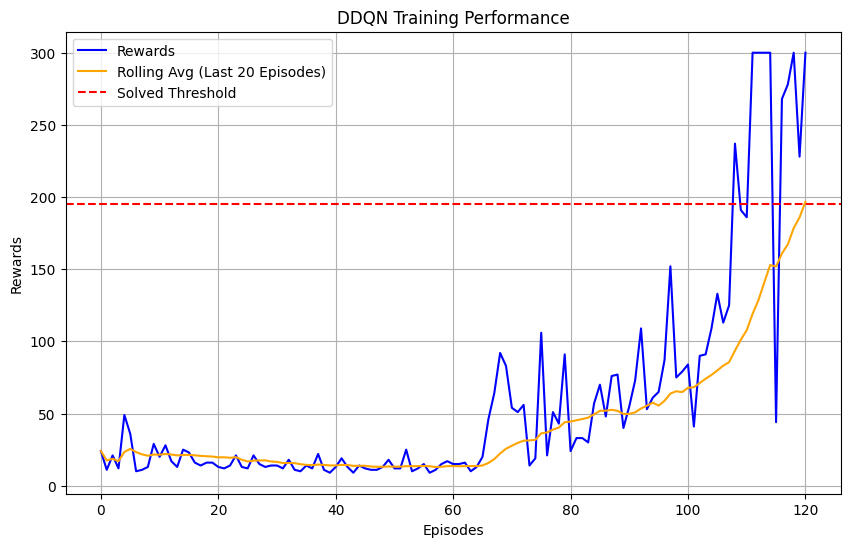

In [11]:
# Plot rewards with rolling average
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards, label='Rewards', color='blue')
plt.plot(rolling_avg_rewards, label='Rolling Avg (Last '+str(ROLLING_WINDOW)+' Episodes)', color='orange')
plt.axhline(y=solved_threshold, color='red', linestyle='--', label='Solved Threshold')
plt.title('DDQN Training Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend()
plt.grid()
plt.show()

#### **Testing 10 episodes with the DDQN trained networks**

In [12]:
# Testing for 10 episodes
start_time = time.time()
max_steps = 500

for e_test in range(10):  # Run 10 test episodes
    state, _ = env.reset()
    state = np.reshape(state, [1, state_size])
    total_reward = 0
    
    steps = 0
    for s in range(max_steps):                            # we limit because sometimes it goes ad-aeternum
        # Use the trained model for testing
        action_vals = model.predict(state, verbose=0)  # Predict action values
        action = np.argmax(action_vals[0])  # Choose the action with the highest Q-value

        next_state, reward, done, _, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])
        total_reward += reward
        state = next_state
        steps = steps + 1

        if done or (steps == max_steps):
            print(f"Test Episode: {e_test + 1}/10, Reward: {total_reward:.2f}, Steps: {steps:3}")
            break

end_time = time.time()
testing_duration = (end_time - start_time) / 60  # Convert to minutes
print(f"Testing completed in {testing_duration:.2f} minutes")

Test Episode: 1/10, Reward: 424.00, Steps: 424
Test Episode: 2/10, Reward: 481.00, Steps: 481
Test Episode: 3/10, Reward: 476.00, Steps: 476
Test Episode: 4/10, Reward: 241.00, Steps: 241
Test Episode: 5/10, Reward: 500.00, Steps: 500
Test Episode: 6/10, Reward: 382.00, Steps: 382
Test Episode: 7/10, Reward: 241.00, Steps: 241
Test Episode: 8/10, Reward: 500.00, Steps: 500
Test Episode: 9/10, Reward: 245.00, Steps: 245
Test Episode: 10/10, Reward: 240.00, Steps: 240
Testing completed in 4.46 minutes


In [13]:
# Test the trained agent with video rendering
# This code is useful if you are using colab otherwise use render_mode='human'
env = gym.make(("CartPole-v1"), render_mode='rgb_array')  # Enable RGB rendering
frames = []  # Store frames for visualization

# Render a single test episode
state, _ = env.reset()
state = np.reshape(state, [1, state_size])
tot_rewards = 0

while True:
    # Use the trained model for action
    action_vals = model.predict(state, verbose=0)  # Predict action values
    action = np.argmax(action_vals[0])           # Choose the action with the highest Q-value

    next_state, reward, done, truncated, _ = env.step(action)
    frames.append(env.render())                  # Save frame for rendering later
    next_state = np.reshape(next_state, [1, state_size])
    tot_rewards += reward
    state = next_state

    if done or truncated:
        print(f"Rendered Test Episode Reward: {tot_rewards:.2f}")
        break

env.close()

# Save the rendered episode as a GIF
def save_frames_as_gif(frames, path='./', filename='CARTPOLE_DDQN.gif'):
    images = [Image.fromarray(frame) for frame in frames]
    gif_path = os.path.join(path, filename)
    images[0].save(gif_path, save_all=True, append_images=images[1:], duration=50, loop=0)
    print(f"Saved GIF to: {gif_path}")

save_frames_as_gif(frames, filename='CARTPOLE_DDQN.gif')


Rendered Test Episode Reward: 421.00
Saved GIF to: ./CARTPOLE_DDQN.gif


In [15]:
import session_info
session_info.show(html=False)

-----
PIL                 11.0.0
gymnasium           1.0.0
keras               3.6.0
matplotlib          3.9.2
numpy               1.26.4
session_info        1.0.0
tensorflow          2.17.1
-----
IPython             8.28.0
jupyter_client      8.6.3
jupyter_core        5.7.2
-----
Python 3.12.3 (main, Jan 17 2025, 18:03:48) [GCC 13.3.0]
Linux-5.15.167.4-microsoft-standard-WSL2-x86_64-with-glibc2.39
-----
Session information updated at 2025-02-09 15:29
